In [1]:
!pwd

/content


In [2]:
import os
os.environ['KAGGLE_CONFIG_DIR'] = "/content"

In [3]:
!kaggle datasets download -d surajghuwalewala/ham1000-segmentation-and-classification

100% 2.58G/2.59G [00:16<00:00, 184MB/s]
100% 2.59G/2.59G [00:16<00:00, 168MB/s]


In [ ]:
!unzip /content/ham1000-segmentation-and-classification.zip

In [5]:
!pip install git+https://github.com/tensorflow/docs

  Cloning https://github.com/tensorflow/docs to /tmp/pip-req-build-wxz810bw
  Running command git clone -q https://github.com/tensorflow/docs /tmp/pip-req-build-wxz810bw
  Created wheel for tensorflow-docs: filename=tensorflow_docs-0.0.0.dev0-py3-none-any.whl size=179891 sha256=c40dd76301b4f47583280b5db85b650f5f88758ed582579bfae8618906cb2408
  Stored in directory: /tmp/pip-ephem-wheel-cache-stv8ag1x/wheels/cc/c4/d8/5341e93b6376c5c929c49469fce21155eb69cef1a4da4ce32c
Successfully built tensorflow-docs


In [6]:
import numpy as np 
import pandas as pd
import tensorflow as tf

from PIL import Image

from tensorflow import keras
import tensorflow_docs as tfdocs
import tensorflow_docs.modeling
import tensorflow_docs.plots
from tensorflow.keras import regularizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.utils.np_utils import to_categorical
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
from matplotlib.pyplot import imshow

In [7]:
def img_np_convert(df, image_path, h, w):
  df['image_id'] = image_path + df['image_id'] +'.jpg'
  df['image'] = df['image_id'].map(lambda x: np.asarray(Image.open(x).resize((h, w))))
  image = np.asarray(df['image'].to_list())

  target_df = df['dx']
  target = pd.get_dummies(data=target_df, columns=['dx']).to_numpy()
  return image, target

In [8]:
def downsample(df, count):
  result=[]
  df_group = df.groupby('label')
  for x in df['label'].unique():
    group = df_group.get_group(x)
    num = int(group['label'].value_counts())
    if num >= count:
      s=group.sample(count, axis=0)
    else:
      s=group.sample(frac=1, axis=0)
    result.append(s)
  return pd.concat(result, axis=0).reset_index(drop=True)

In [9]:
def oversample(df, count, rs=42):
  lst = [df]
  for class_index, group in df.groupby('label'):
      lst.append(group.sample(count-len(group), replace=True, random_state=rs))
  df_new = pd.concat(lst)
  return df_new

In [10]:
df_o = pd.read_csv('../content/drive/MyDrive/DSE_I2100/data/HAM10000_metadata.csv')
image_path = r'../content/images/'
h = 240
w = 240
X, y = img_np_convert(df_o, image_path, h, w)

In [11]:
tain_size=0.7
valid_size = 0.1
test_size = 0.2
valid_test_split = valid_size / test_size

X_train, X_test_val, y_train, y_test_val = train_test_split(X, y, test_size=1-tain_size, shuffle=True, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_test_val, y_test_val, test_size=valid_test_split, shuffle=True, random_state=42)

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)
print(X_val.shape, y_val.shape)

(7010, 240, 240, 3) (7010, 7)
(1503, 240, 240, 3) (1503, 7)
(1502, 240, 240, 3) (1502, 7)


In [12]:
class_weight={}
labels = list(df_o['dx'].unique())
labels.sort()
count = df_o['dx'].value_counts()
for idx in range(7):
  class_weight[idx] = count['nv']/count[labels[idx]]

In [13]:
class_weight

{0: 20.504587155963304,
 1: 13.044747081712062,
 2: 6.101000909918107,
 3: 58.30434782608695,
 4: 6.024258760107816,
 5: 1.0,
 6: 47.21830985915493}

In [14]:
def get_callbacks():
  return [
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, verbose=1, mode='auto', restore_best_weights=True),
    tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, verbose=1, mode='auto')      
  ]

In [15]:
histories = {}

In [16]:
channels = 3
img_shape = (h, w, channels)

In [17]:
# Create the base model with EfficientNetB1
base_model = tf.keras.applications.EfficientNetB1(input_shape=img_shape, include_top=False, weights='imagenet', pooling='max')

27033600/27018416 [==============================] - 0s 0us/step


In [ ]:
base_model.summary()

In [19]:
Normalizator_layer = keras.layers.BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001 )

In [20]:
prediction_layer = keras.layers.Dense(7, activation='softmax')

In [21]:
model = tf.keras.Sequential([
  base_model,
  Normalizator_layer,
  keras.layers.Dense(256, 
                     kernel_regularizer = regularizers.l2(l = 0.02),
                     activity_regularizer=regularizers.l1(0.01),
                     bias_regularizer=regularizers.l1(0.01), 
                     activation='relu'),
  keras.layers.Dropout(rate=.5, seed=42),
  prediction_layer                           
])

In [22]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb1 (Functional)  (None, 1280)             6575239   
                                                                 
 batch_normalization (BatchN  (None, 1280)             5120      
 ormalization)                                                   
                                                                 
 dense_1 (Dense)             (None, 256)               327936    
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense (Dense)               (None, 7)                 1799      
                                                                 
Total params: 6,910,094
Trainable params: 6,845,479
Non-trainable params: 64,615
_________________________________________

In [23]:
base_learning_rate = 0.001
model.compile(optimizer=tf.keras.optimizers.Adamax(learning_rate=base_learning_rate),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [24]:
history = model.fit(X_train,
                    y_train, 
                    epochs=30, 
                    validation_data=(X_val, y_val), 
                    callbacks=get_callbacks(),
                    class_weight=class_weight)

Epoch 1/30
220/220 [==============================] - 115s 396ms/step - loss: 17.5295 - accuracy: 0.4083 - val_loss: 10.6361 - val_accuracy: 0.4960 - lr: 0.0010
Epoch 2/30
220/220 [==============================] - 83s 378ms/step - loss: 13.4598 - accuracy: 0.5866 - val_loss: 10.1337 - val_accuracy: 0.6644 - lr: 0.0010
Epoch 3/30
220/220 [==============================] - 83s 378ms/step - loss: 11.9467 - accuracy: 0.6591 - val_loss: 9.4302 - val_accuracy: 0.7244 - lr: 0.0010
Epoch 4/30
 37/220 [====>.........................] - ETA: 1:06 - loss: 11.2448 - accuracy: 0.7044

KeyboardInterrupt: ignored

In [17]:
histories['EfficientNetB1'] = history

(0.0, 1.0)

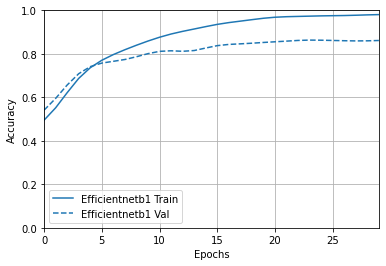

In [18]:
plotter = tfdocs.plots.HistoryPlotter(metric = 'accuracy', smoothing_std=10)
plotter.plot(histories)
plt.ylim([0, 1])

(0.0, 20.0)

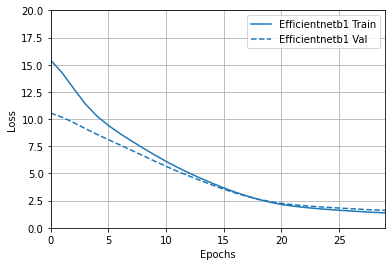

In [19]:
plotter = tfdocs.plots.HistoryPlotter(metric = 'loss', smoothing_std=10)
plotter.plot(histories)
plt.ylim([0, 20])

In [20]:
pred=model.predict(X_test) 

In [21]:
y_pred=[]
for p in pred:
  pred_index=np.argmax(p)
  y_pred.append(pred_index)

In [24]:
y_ture=[]
for p in y_test:
  pred_index=np.argmax(p)
  y_ture.append(pred_index)

In [ ]:
y_true = np.array(labels)
y_pred = np.array(y_pred)

In [ ]:
cm = confusion_matrix(y_true, y_pred)

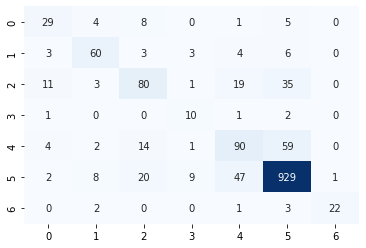

In [ ]:
sns.heatmap(cm, annot=True, vmin=0, fmt='g', cmap='Blues', cbar=False) 

In [ ]:
class_dict=test_gen.class_indices
new_dict={}
for key,value in class_dict.items():
  new_dict[value]=key
classes=list(new_dict.values())

In [ ]:
clr = classification_report(y_true, y_pred, target_names=classes)

In [ ]:
print(clr)

              precision    recall  f1-score   support

       AKIEC       0.58      0.62      0.60        47
         BCC       0.76      0.76      0.76        79
         BKL       0.64      0.54      0.58       149
          DF       0.42      0.71      0.53        14
         MEL       0.55      0.53      0.54       170
          NV       0.89      0.91      0.90      1016
        VASC       0.96      0.79      0.86        28

    accuracy                           0.81      1503
   macro avg       0.69      0.69      0.68      1503
weighted avg       0.81      0.81      0.81      1503



In [ ]:
model.evaluate(test_gen)

38/38 [==============================] - 15s 384ms/step - loss: 1.5234 - accuracy: 0.8117


[1.5233595371246338, 0.8117099404335022]